<a href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH02_FLYNN_ML4DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2: Ligand-based Screening: Filtering & Similarity Searching

## Setup

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 32.8 MB/s eta 0:00:00


In [ ]:
!gzip -d data/Specs.sdf.gz

In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
np.random.seed(42)

colors = ["#A20025", "#6C8EBF"]
sns.set_palette(sns.color_palette(colors))

In [ ]:
from rdkit.Chem import Draw
d2d = Draw.MolDraw2DSVG(-1, -1)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
dopts.setHighlightColour((.635,.0,.145,.4))
dopts.baseFontSize = 1.0
dopts.additionalAtomLabelPadding = 0.15
dopts.dotsPerAngstrom = 100

## Loading a Virtual Screening Library

### Understanding the Dataset as a Structure Data File

In [ ]:
from rdkit.Chem import PandasTools

specs = PandasTools.LoadSDF(
  "data/Specs.sdf", smilesName='smiles', molColName=None
)[["PUBCHEM_SUBSTANCE_ID", "smiles"]]

PandasTools.AddMoleculeColumnToFrame(specs, 'smiles', 'mol')

[17:46:58] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:46:58] ERROR: Could not sanitize molecule ending on line 6498564
[17:46:58] ERROR: Explicit valence for atom # 9 N, 4, is greater than permitted
[17:47:09] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:47:09] ERROR: Could not sanitize molecule ending on line 8305274
[17:47:09] ERROR: Explicit valence for atom # 9 N, 4, is greater than permitted
[17:47:09] Explicit valence for atom # 10 N, 4, is greater than permitted
[17:47:09] ERROR: Could not sanitize molecule ending on line 8315499
[17:47:09] ERROR: Explicit valence for atom # 10 N, 4, is greater than permitted
[17:48:34] Explicit valence for atom # 2 N, 4, is greater than permitted
[17:48:34] ERROR: Could not sanitize molecule ending on line 20625298
[17:48:34] ERROR: Explicit valence for atom # 2 N, 4, is greater than permitted


In [ ]:
specs.shape

(212670, 3)

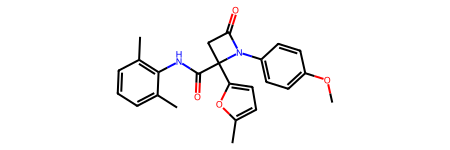

In [ ]:
from rdkit.Chem import MolFromSmiles

mol = MolFromSmiles(specs.smiles[0])
mol

In [ ]:
type(mol)

rdkit.Chem.rdchem.Mol

In [ ]:
img = Draw.MolsToGridImage(
  mols=[mol], molsPerRow=1, useSVG=True, drawOptions=dopts,
)

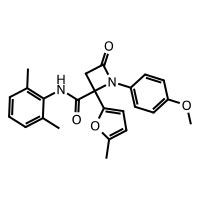

In [ ]:
img

In [ ]:
with open("example_mol.svg", "w") as f:
  f.write(img.data)

### Molecular Descriptors

In [ ]:
from rdkit.Chem import Descriptors
print(len(Descriptors._descList))
print(Descriptors._descList[:3])

209
[('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x79b9e95232e0>), ('MaxEStateIndex', <function MaxEStateIndex at 0x79b9e9523400>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x79b9e9523250>)]


In [ ]:
RDKIT_DESCRIPTORS = { desc : func for desc, func in Descriptors._descList }
RO5_PROPS = ['ExactMolWt', 'NumHAcceptors', 'NumHDonors', 'MolLogP']

def compute_descriptors(mol, func, missing_val=None):
  try:
    return func(mol)
  except:
    return missing_val

for desc in RO5_PROPS:
  specs[desc] = specs["mol"].apply(
    lambda x: compute_descriptors(x, RDKIT_DESCRIPTORS[desc])
  )

specs = specs.dropna(subset=RO5_PROPS)

In [ ]:
specs.head()

,PUBCHEM_SUBSTANCE_ID,smiles,mol,ExactMolWt,NumHAcceptors,NumHDonors,MolLogP
0,469753576,COc1ccc(N2C(=O)CC2(C(=O)Nc2c(C)cccc2C)c2ccc(C)...,<rdkit.Chem.rdchem.Mol object at 0x7b5f958bbf40>,404.173607,4,1,4.48436
1,469753575,CCOC(=O)c1ccc(NC2SC(=O)N(Cc3ccc(C(=O)OC)cc3)C2...,<rdkit.Chem.rdchem.Mol object at 0x7b5f958bbe60>,428.104207,8,1,3.28350
2,469753574,Cc1cc(Br)cc([N+](=O)[O-])c1N,<rdkit.Chem.rdchem.Mol object at 0x7b5f958bbdf0>,229.969090,3,1,2.24792
3,469753573,Oc1ccc(CN2CCN(c3ccccn3)CC2)c2cccnc12,<rdkit.Chem.rdchem.Mol object at 0x7b5f958bbd80>,320.163711,5,1,2.65760
4,469753572,Cc1cccnc1C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x7b5f958bbd10>,136.063663,2,1,0.48892


In [ ]:
specs.describe()

,ExactMolWt,NumHAcceptors,NumHDonors,MolLogP
count,212670.000000,212670.000000,212670.000000,212670.000000
mean,371.738321,4.512531,0.990046,3.917192
std,93.585321,1.905391,0.796672,1.587613
min,68.025421,0.000000,0.000000,-4.195200
25%,306.136828,3.000000,0.000000,2.885940
50%,369.020203,4.000000,1.000000,3.855710
75%,432.133005,6.000000,1.000000,4.923815
max,1161.548016,21.000000,8.000000,15.329400


## Compound Filters

### Property-based Filters

In [ ]:
specs["ro5_compliant"] = np.where(
    (specs.ExactMolWt <= 500) &
    (specs.NumHAcceptors <= 10) &
    (specs.NumHDonors <= 5) &
    (specs.MolLogP <= 5), True, False
)

specs_ro5_compliant = specs[specs["ro5_compliant"]]
specs_ro5_violated = specs[~specs["ro5_compliant"]]

In [ ]:
print(f"Compound library size pre-RO5 filter: {len(specs)}")
print(f"Compound library size post-RO5 filter: {len(specs_ro5_compliant)}")

Compound library size pre-RO5 filter: 212670
Compound library size post-RO5 filter: 157365


In [ ]:
specs_ro5_compliant.describe()

,ExactMolWt,NumHAcceptors,NumHDonors,MolLogP
count,157365.000000,157365.000000,157365.000000,157365.000000
mean,339.317811,4.364001,1.029181,3.246275
std,74.660708,1.799713,0.804148,1.117352
min,68.025421,0.000000,0.000000,-3.600100
25%,287.132157,3.000000,0.000000,2.569920
50%,340.215078,4.000000,1.000000,3.396900
75%,393.241627,6.000000,1.000000,4.100490
max,499.986418,10.000000,5.000000,4.999920


**Code for Figure 2.6. Comparison of RO5 compliant and non-compliant distributions for exact molecular weight**

<Figure size 640x480 with 0 Axes>

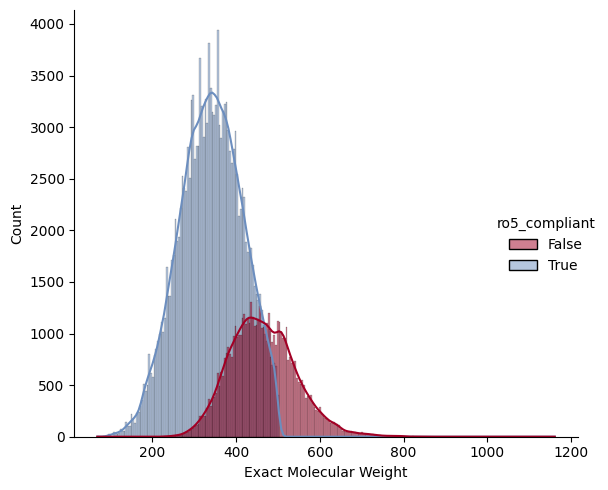

In [ ]:
plt.figure()
sns.displot(specs, x='ExactMolWt', hue='ro5_compliant', kde=True)
plt.xlabel('Exact Molecular Weight')
plt.tight_layout()
plt.savefig('exactmolwt_dist.png', bbox_inches='tight', dpi=600)
plt.savefig('exactmolwt_dist.pdf', bbox_inches='tight', dpi=600)

In [ ]:
ro5_avgs_df = pd.DataFrame(data = {
    'property' : ['NumHAcceptors', 'NumHDonors', 'MolLogP'],
    'RO5 Compliant Mols' : [specs_ro5_compliant['NumHAcceptors'].mean(), specs_ro5_compliant['NumHDonors'].mean(), specs_ro5_compliant['MolLogP'].mean()],
    'RO5 Violated Mols' : [specs_ro5_violated['NumHAcceptors'].mean(), specs_ro5_violated['NumHDonors'].mean(), specs_ro5_violated['MolLogP'].mean()]
})

In [ ]:
ro5_avgs_df['rel_change'] = (ro5_avgs_df['RO5 Compliant Mols'] - ro5_avgs_df['RO5 Violated Mols']) / ro5_avgs_df['RO5 Violated Mols']
ordered_df = ro5_avgs_df.sort_values(by='RO5 Compliant Mols')
my_range = range(1, len(ordered_df.index) + 1)

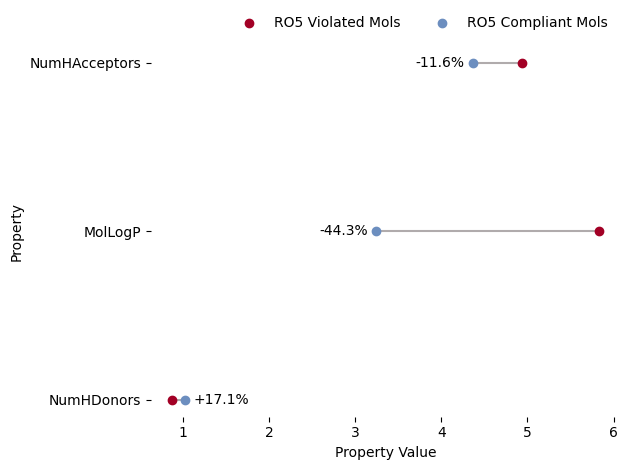

In [ ]:
plt.figure()
plt.axes(frameon=False)
plt.hlines(y=my_range, xmin=ordered_df['RO5 Violated Mols'], xmax=ordered_df['RO5 Compliant Mols'], color='#B0ABAC')

for x, y, ann in zip(ordered_df['RO5 Compliant Mols'], my_range, ordered_df['rel_change']):
  if y > 1:
    plt.text(x - 0.1, y, f'{ann * 100:.1f}%', ha='right', va='center')
  else:
    plt.text(x + 0.1, y, f'+{ann * 100:.1f}%', ha='left', va='center')

plt.scatter(ordered_df['RO5 Violated Mols'], my_range, zorder=3, label="RO5 Violated Mols")
plt.scatter(ordered_df['RO5 Compliant Mols'], my_range, zorder=3, label="RO5 Compliant Mols")
plt.legend(ncol=2, bbox_to_anchor=(1.,1.01), loc="lower right", frameon=False)
#plt.legend(loc="lower right", frameon=False)

plt.yticks(my_range, ordered_df['property'])
plt.xlabel('Property Value')
plt.ylabel('Property')
plt.tight_layout()
plt.savefig('relchange_ro5.png', bbox_inches='tight', dpi=600)
plt.savefig('relchange_ro5.pdf', bbox_inches='tight', dpi=600)

### Structure-based Filters

In [ ]:
from rdkit.Chem import FilterCatalog
filter_params = FilterCatalog.FilterCatalogParams()
filter_params.AddCatalog(filter_params.FilterCatalogs.PAINS)
filter_params.AddCatalog(filter_params.FilterCatalogs.BRENK)
catalog = FilterCatalog.FilterCatalog(filter_params)

In [ ]:
specs_ro5_compliant["PAINS_BRENK_compliant"] = specs_ro5_compliant['mol'].apply(catalog.HasMatch)

<ipython-input-21-5d85866d3362>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_ro5_compliant["PAINS_BRENK_compliant"] = specs_ro5_compliant['mol'].apply(catalog.HasMatch)


In [ ]:
specs_ro5_pains_brenk_compliant = specs_ro5_compliant[specs_ro5_compliant["PAINS_BRENK_compliant"]]

In [ ]:
print(f"SPECS compounds compliant with RO5, PAINS, and BRENK: {specs_ro5_compliant['PAINS_BRENK_compliant'].sum()}")

SPECS compounds compliant with RO5, PAINS, and BRENK: 73783


In [ ]:
from rdkit.Chem import Draw, MolFromSmarts
glaxo_alerts = pd.read_csv("data/glaxo_structural_alerts.csv")
glaxo_alerts["ROMol"] = glaxo_alerts.smarts.apply(MolFromSmarts)
print(f"Number of Glaxo Wellcome structural alerts: {len(glaxo_alerts)}")

Number of Glaxo Wellcome structural alerts: 55


**Code for Figure 2.8. Example substructures within the Glaxo Wllcome hard filters**

In [ ]:
d2d = Draw.MolDraw2DSVG(-1, -1)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
dopts.setHighlightColour((.635,.0,.145,.4))
dopts.additionalAtomLabelPadding = 0.15

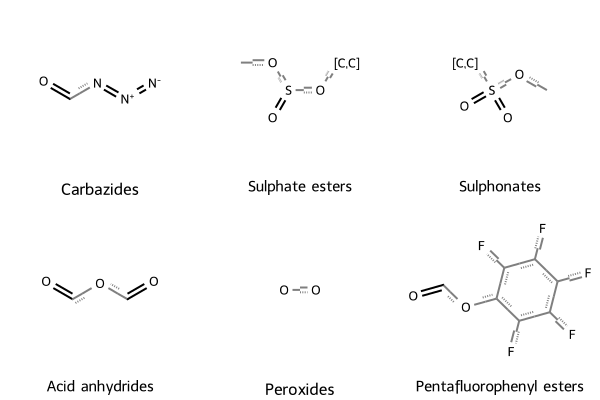

In [ ]:
img = Draw.MolsToGridImage(
  mols=glaxo_alerts["ROMol"].iloc[2:8].tolist(), molsPerRow=3, legends=glaxo_alerts["description"].iloc[2:8].tolist(), useSVG=True, drawOptions=dopts,
)
img

In [ ]:
with open("glaxo_alerts_examples.svg", "w") as f:
  f.write(img.data)

In [ ]:
glaxo_sa_matches = []
def glaxo_filter(mol, alerts):
  match_ = False
  for _, alert in alerts.iterrows():
    if mol.HasSubstructMatch(alert.ROMol):
      glaxo_sa_matches.append({
        "mol": mol,
        "alert": alert.ROMol,
        "description": alert.description,
      })
      match_ = True
  return match_

specs_ro5_pains_brenk_compliant["GLAXO_compliant"] = ~specs_ro5_pains_brenk_compliant['mol'].apply(glaxo_filter, alerts=glaxo_alerts)
specs_filtered = specs_ro5_pains_brenk_compliant[specs_ro5_pains_brenk_compliant["GLAXO_compliant"]]
glaxo_sa_matches = pd.DataFrame(glaxo_sa_matches)
print(f"Compound library size after filtering: {specs_ro5_pains_brenk_compliant['GLAXO_compliant'].sum()}")
glaxo_sa_matches["description"].value_counts()[:5]

Compound library size after filtering: 61372


<ipython-input-25-c2d7bc781f0d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_ro5_pains_brenk_compliant["GLAXO_compliant"] = ~specs_ro5_pains_brenk_compliant['mol'].apply(glaxo_filter, alerts=glaxo_alerts)


acylhydrazide                                8751
Thiols                                       1004
Reactive alkyl halides                        890
Cytochalasin derivatives                      418
Aliphatic methylene chains 7 or more long     360
Name: description, dtype: int64

**Code for Figure 2.9. Examples of hits against the Glaxo Wellcome hard filters**

In [ ]:
d2d = Draw.MolDraw2DSVG(-1, -1)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
dopts.setHighlightColour((.635,.0,.145,.1))
dopts.baseFontSize = 1.0
dopts.additionalAtomLabelPadding = 0.15

In [ ]:
highlights = [mol.GetSubstructMatch(alert) for mol, alert in zip(glaxo_sa_matches.mol, glaxo_sa_matches.alert)]

In [ ]:
img = Draw.MolsToGridImage(
  glaxo_sa_matches.mol.iloc[2:8].tolist(),
  highlightAtomLists=highlights[2:8],
  molsPerRow=3,
  #subImgSize=(300, 300),
  legends=glaxo_sa_matches.description.iloc[2:8].tolist(),
  drawOptions=dopts,
  useSVG=True
)

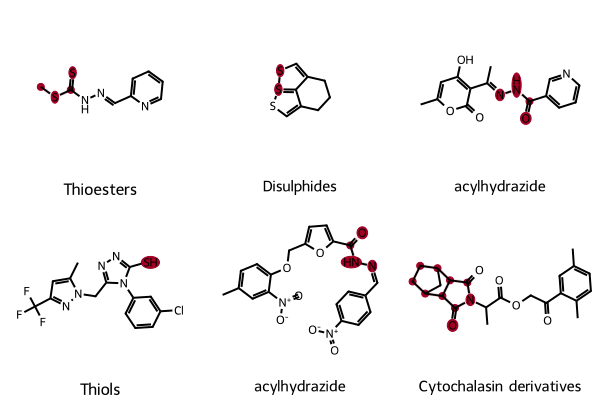

In [ ]:
img

In [ ]:
with open("glaxo_alerts_matches.svg", "w") as f:
  f.write(img.data)

In [ ]:
specs_filtered.shape

(61372, 10)

## Fingerprints: Representing Molecules as Numbers

### Fingerprinting our Library

In [ ]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

def compute_fingerprint(mol, r, nBits):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, r, nBits=nBits)
    return fp

In [ ]:
specs_filtered["morgan_fp_r2_b2048"] = specs_filtered["mol"].apply(compute_fingerprint, r=2, nBits=2048)

<ipython-input-38-5908e449411e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_filtered["morgan_fp_r2_b2048"] = specs_filtered["mol"].apply(compute_fingerprint, r=2, nBits=2048)


**Code for Figure 2.15. Example decomposition of a molecule into several fingerprint features**

In [ ]:
def draw_fragment_from_bit(mol, bit_number):
  """ Given an rdkit mol, draws the local fragment that corresponds to the set bit of ecfp featurization.

  If the bit is not set, will throw an error.
  """
  bi = {}
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
  try:
    svg = Draw.DrawMorganBit(mol, bit_number, bi, useSVG=True)
  except:
    raise ValueError(f"Featurization of mol doesn't have bit {bit_number} set")
  return svg

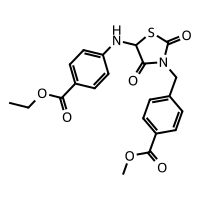

In [ ]:
example_mol = specs_filtered.mol.iloc[0]
img = Draw.MolsToGridImage(
  mols=[example_mol], molsPerRow=1, useSVG=True, drawOptions=dopts,
)
with open(f"fp_decomposition_example_mol.svg", "w") as f:
  f.write(img.data)
img

In [ ]:
example_fp = specs_filtered.morgan_fp_r2_b2048.iloc[0]

In [ ]:
fp_hit_indices = [idx for idx, bit in enumerate(example_fp) if bit][:5]

In [ ]:
fp_hit_indices

[5, 66, 74, 80, 145]

In [ ]:
example_bits = [draw_fragment_from_bit(example_mol, hit_idx) for hit_idx in fp_hit_indices]

In [ ]:
for i, bit_img in enumerate(example_bits):
  with open(f"fp_decomposition_bit{i}.svg", "w") as f:
    f.write(bit_img.data)

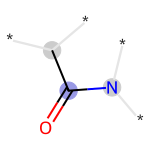

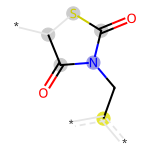

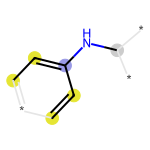

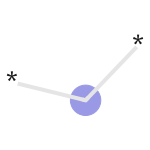

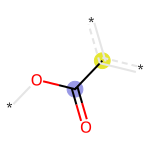

In [ ]:
display(*example_bits)

## Similarity Searching

### Defining "Similarity"

In [ ]:
malaria_box = pd.read_excel("data/MalariaBox400compoundsDec2014.xls", usecols=["HEOS_COMPOUND_ID", "Smiles"])
PandasTools.AddMoleculeColumnToFrame(malaria_box, 'Smiles', 'mol')
malaria_box["morgan_fp_r2_b2048"] = malaria_box["mol"].apply(compute_fingerprint, r=2, nBits=2048)

query = malaria_box.morgan_fp_r2_b2048.iloc[236]
mols = specs_filtered.morgan_fp_r2_b2048.tolist()

specs_filtered["tanimoto_sim"] = DataStructs.BulkTanimotoSimilarity(query, mols)
specs_filtered["dice_sim"] = DataStructs.BulkDiceSimilarity(query, mols)

<ipython-input-48-19973eda0237>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_filtered["tanimoto_sim"] = DataStructs.BulkTanimotoSimilarity(query, mols)
<ipython-input-48-19973eda0237>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_filtered["dice_sim"] = DataStructs.BulkDiceSimilarity(query, mols)


**Code for Figure 2.17. Tanimoto and Dice similarity scores of molecules with high and low similarity to a Malaria Box compound**

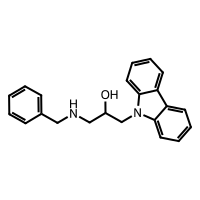

In [ ]:
img = Draw.MolsToGridImage(
  mols=[malaria_box.mol.iloc[236]], molsPerRow=1, useSVG=True, drawOptions=dopts,
)
with open("example_malaria_box_mol.svg", "w") as f:
  f.write(img.data)
img

In [ ]:
def visualize_similarity_extremes(df, sim_col, sim_col_2=None, n=3):
  df_ordered = df.sort_values([sim_col], ascending=False).reset_index()
  extremes = pd.concat([df_ordered[:n], df_ordered.dropna()[-n:]])

  if sim_col_2:
    legend_text=[f"Tani: {x:.2f}\tDice: {y:.2f}" for x, y in zip(extremes[sim_col], extremes[sim_col_2])]
  else:
    legend_text=[f"{x:.2f}" for x in extremes[sim_col]]

  return Draw.MolsToGridImage(
    extremes.mol, molsPerRow=3, legends=legend_text, useSVG=True, drawOptions=dopts
  )

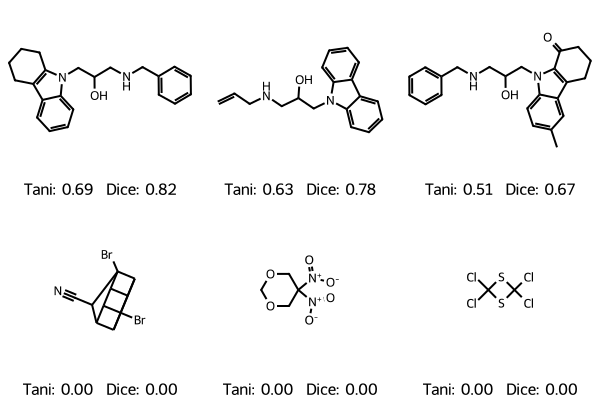

In [ ]:
img = visualize_similarity_extremes(specs_filtered, "tanimoto_sim", "dice_sim")
img

In [ ]:
with open("example_tani_dice_sim.svg", "w") as f:
  f.write(img.data)

**Code for Figure 2.18. Relationship between Tanimoto and Dice similarity scores**

<Figure size 640x480 with 0 Axes>

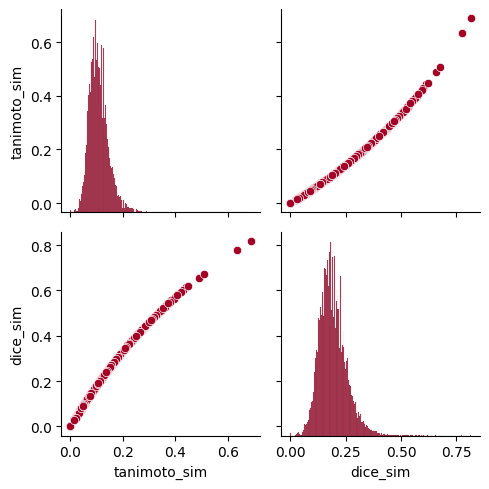

In [ ]:
plt.figure()
sns.pairplot(specs_filtered[["tanimoto_sim", "dice_sim"]])
plt.tight_layout()
plt.savefig('sim_pairplot.png', bbox_inches='tight', dpi=600)
plt.savefig('sim_pairplot.pdf', bbox_inches='tight', dpi=600)

**Code for searching for similar matches and saving the top matches**

In [ ]:
from collections import defaultdict
specs_filtered = specs_filtered.reset_index(drop=True)
mols = specs_filtered.morgan_fp_r2_b2048.tolist()
matches = defaultdict(int)

for query in malaria_box.morgan_fp_r2_b2048:
 dice_sim = DataStructs.BulkDiceSimilarity(query, mols)
 matches.update({
    idx : max(sim, matches[idx]) for idx, sim in enumerate(dice_sim) if sim >= 0.65
 })

print(len(matches))

1225


In [ ]:
import heapq
budget = 1000
heap = []
for idx, sim in matches.items():
  heapq.heappush(heap, (-1 * sim, idx))

top_matches = []
for i in range(budget):
  top_matches.append(heapq.heappop(heap)[1])

In [ ]:
top_matches

[343, 58, 532, 156, 445, 49, 387, 485, 384, 34, 44, 30]

In [ ]:
specs_hits_to_malaria_box = specs_filtered.filter(items=top_matches, axis=0)

In [ ]:
specs_hits_to_malaria_box.to_csv("specs_hits_to_malaria_box.csv", columns=["PUBCHEM_SUBSTANCE_ID", "smiles"], index=False)